In [40]:
import numpy as np
import matplotlib.pyplot as plt

from ensemblecalibration.calibration.calibration_estimates import skce_ul_obj, skce_uq_obj, skceul, skceuq
from ensemblecalibration.calibration.experiments import experiment_h0, experiment_h1 
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.sampling import multinomial_label_sampling
from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.p_value_analysis import _simulation_pvals

In [26]:
p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01)

### p-value Analysis to visualize correlation between p-value and value of statistic

In [39]:
result_skceuq = _simulation_pvals(tests=config_p_value_analysis, N=100, M=10, K=10, R=100, u=0.01, experiment=experiment_h0)

100%|██████████| 100/100 [17:25<00:00, 10.45s/it]


In [45]:
result_skceuq

({'SKCEul': array([[-3.22768003e-03, -7.27664479e-03,  4.22855412e-03,
          -9.24423217e-03,  1.07740361e-03, -1.26631107e-03,
           7.11600727e-04,  4.80869500e-03,  3.20643769e-03,
           4.73237481e-04, -5.97858900e-03, -1.35865330e-02,
          -2.28664913e-04,  9.12527020e-04, -2.06737521e-03,
          -4.20977400e-03, -1.83501428e-03,  1.25552957e-03,
           1.01891408e-02,  5.19793658e-04, -2.17592539e-03,
           1.82533862e-03,  1.14027917e-03, -2.69604333e-03,
           7.80056814e-04, -3.29485615e-03, -5.79369804e-03,
          -5.03223257e-03, -1.86183442e-03,  1.08308644e-02,
           1.46798714e-03,  5.55816637e-03,  6.51523089e-03,
           3.23114320e-03,  5.02086383e-03,  1.96157415e-03,
          -3.08975163e-03,  6.14272667e-03,  1.55499081e-03,
          -6.49755880e-04, -3.08114376e-03,  3.71847502e-04,
           7.86454548e-05, -2.17148290e-03, -4.10205983e-04,
          -5.92105828e-03,  2.75241840e-03, -1.22426563e-03,
           2.7

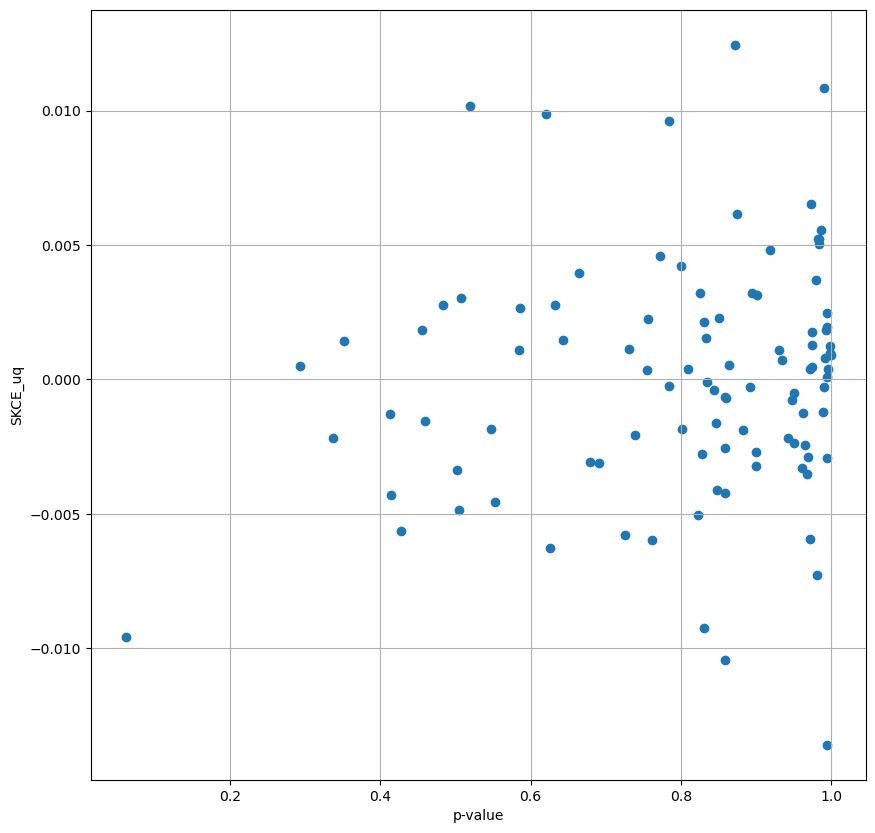

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(result_skceuq[0]["SKCEul"][1, :], result_skceuq[0]["SKCEul"][0, :])
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_uq")
plt.grid()

